In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float((curLine[-1])))
    return dataMat,labelMat

In [5]:
# 定义decision stump 单层决策树
def stumpClasify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0],1)) # 返回划分结果矩阵
    # 对应数值数据有两种分类方向
    # 对于标称数据有等于和不等两种情况（决策树中的情况）
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0 # 平行于坐标轴的直线为阈值，分类，小于阈值的为-1.0 ，
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0 # 大于阈值的为 -1.0 两种分类方向
    return retArray

In [6]:
# 寻找最优单层树
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMatrix = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0 # 步数，决定可能的取值情况
    bestStump = {}  # 存储最优单层树
    bestClassEst = np.mat(np.zeros((m,1))) # 存储最优单层树的分类误差
    minError = np.inf # 初始化误差为无穷大
    for i in range(n): # 对于每个维度上的特征
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1): # 对于每一个可能取值的步长，这里额外处理取值范围之外的点
            for inequal in ['lt','gt']: # 对于该取值下的两种不同分类方向
                threshVal = rangeMin + j*stepSize # 计算此时的阈值
                predictedVals = stumpClasify(dataMatrix,i,threshVal,inequal)
                errArr = np.mat(np.ones((m,1))) # 创建一个错误分类项挑选矩阵
                errArr[predictedVals == labelMatrix] = 0 # 挑选
                # 这里是评估在相同权重D情况下，最优的单层决策树的评估值，
                #也是用于更新alpha以及D的错误率
                weightedError = D.T*errArr # 计算加权错误？？？ 
#                 print("split: dim %d, thresh %.2f, thresh inequal: %s, the weighted error is %.3f"%(i,threshVal,inequal,weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst = predictedVals
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClassEst

In [42]:
 # adaBoost过程
def adaBoostTrainDS(dataArr,classLabels,numIt = 40):
    weakClassArr = [] # 分类器列表
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m,1))/m) # 初始样本权重矩阵
    aggClassEst = np.mat(np.zeros((m,1))) # 计算最终分类结果的矩阵
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D) # 寻找当前D情况下的最优DS decision stump
#         print('D;'+str(D.T))

        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16))) # 计算当前DS的权重并存贮
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
#         print('class:'+str(classEst.T))

        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)  # np.mat(classLabels).T,classEst 的对应相乘，决定了D是增加还是减小
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum() # 这里要使用更新权重分子后的D来计算sum，以保证D总和为1，D 本身是一个概率分布向量

        aggClassEst += alpha*classEst # 概率估计值，是概率值，还不是最终分类标签
#         print('aggClassEst:'+str(aggClassEst.T))
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1))) 
        # np.sign(aggClassEst) 将概率估计结果转为label
        # np.sign(aggClassEst) != np.mat(classLabels).T 产生一个分类准确性 boolean 矩阵
        # 与 np.ones((m,1)) 的对应相乘 将 boolean 转换为 1 或 0
        errorRate = aggErrors.sum()/m
        print('total error: '+str(errorRate))
        if errorRate == 0.0 : break
    return weakClassArr,aggClassEst

In [28]:
# 分类结果进行加权求和
def adaClassify(dataToClass,classiferArr):
    dataMatrix = np.mat(dataToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classiferArr)):
        classEst = stumpClasify(dataMatrix,classiferArr[i]['dim'],classiferArr[i]['thresh'],classiferArr[i]['ineq'])
        aggClassEst += classiferArr[i]['alpha']*classEst 
#         print(aggClassEst)
    return np.sign(aggClassEst)  

In [23]:
dataArr,labelArr = loadDataSet('./horseColicTraining2.txt')

In [24]:
# 由于实际问题的复杂性，所以total error 不一定能收敛到0，一般会稳定到一定的值，此时numItr的设置较为关键
# 对于好的数据集，达到最小误差后再增加numItr不会我可没那会有过拟合的问题
classifierArr，aggClassEst= adaBoostTrainDS(dataArr,labelArr,50)

total error: 0.284280936455
total error: 0.284280936455
total error: 0.247491638796
total error: 0.247491638796
total error: 0.254180602007
total error: 0.240802675585
total error: 0.240802675585
total error: 0.220735785953
total error: 0.247491638796
total error: 0.230769230769
total error: 0.240802675585
total error: 0.214046822742
total error: 0.227424749164
total error: 0.217391304348
total error: 0.220735785953
total error: 0.217391304348
total error: 0.224080267559
total error: 0.224080267559
total error: 0.230769230769
total error: 0.224080267559
total error: 0.214046822742
total error: 0.207357859532
total error: 0.224080267559
total error: 0.224080267559
total error: 0.214046822742
total error: 0.220735785953
total error: 0.204013377926
total error: 0.207357859532
total error: 0.210702341137
total error: 0.217391304348
total error: 0.210702341137
total error: 0.217391304348
total error: 0.207357859532
total error: 0.210702341137
total error: 0.207357859532
total error: 0.20735

In [25]:
testDataArr,testLabelArr = loadDataSet('./horseColicTest2.txt')

In [32]:
prediction = adaClassify(testDataArr,classifierArr)
prediction

matrix([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 

In [36]:
# 在30%缺失数据的情况下
errorArr = np.mat(np.ones((67,1)))
errorArr[prediction!= np.mat(testLabelArr).T].sum()/67

0.20895522388059701

In [275]:
def plotROC(predStrengths,classLabels,ax=None,usecolor='blue'):
    cur = (1.0,1.0) # 起始坐标
    ySum = 0.0 # 统计纵坐标高度，用于计算AUC
    numPosClas = np.sum(np.mat(classLabels) == 1.0) # 统计正样本数量
    yStep = 1/numPosClas # TPR的步长
    xStep = 1/(len(classLabels)-numPosClas) # FPR的步长
    sortedIndicies = predStrengths.T.argsort(1) # 指定排序方向，这里是增序排列，所以之后的设置逻辑是设置每一个样本为反
    if ax == None:
        fig = plt.figure()
        fig.clf()
        ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]: #分别设置每一个样本为反
        if classLabels[index] == 1.0: # 这里出现一个FN，TPR降低
            delX = 0
            delY = yStep
        else: # 这里出现一个TN FPR降低
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c=usecolor)
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC for AdaBoost")
    ax.axis([0,1,0,1])
    print('AOC:'+str(ySum*xStep))
#     plt.show()
    return ax

In [101]:
classifierArr,addClassEst = adaBoostTrainDS(dataArr,labelArr,50)

total error: 0.284280936455
total error: 0.284280936455
total error: 0.247491638796
total error: 0.247491638796
total error: 0.254180602007
total error: 0.240802675585
total error: 0.240802675585
total error: 0.220735785953
total error: 0.247491638796
total error: 0.230769230769
total error: 0.240802675585
total error: 0.214046822742
total error: 0.227424749164
total error: 0.217391304348
total error: 0.220735785953
total error: 0.217391304348
total error: 0.224080267559
total error: 0.224080267559
total error: 0.230769230769
total error: 0.224080267559
total error: 0.214046822742
total error: 0.207357859532
total error: 0.224080267559
total error: 0.224080267559
total error: 0.214046822742
total error: 0.220735785953
total error: 0.204013377926
total error: 0.207357859532
total error: 0.210702341137
total error: 0.217391304348
total error: 0.210702341137
total error: 0.217391304348
total error: 0.207357859532
total error: 0.210702341137
total error: 0.207357859532
total error: 0.20735

In [273]:
ax = plotROC(addClassEst,labelArr)

AOC:0.895394187018


In [105]:
classifierArr10,addClassEst10 = adaBoostTrainDS(dataArr,labelArr,10)

total error: 0.284280936455
total error: 0.284280936455
total error: 0.247491638796
total error: 0.247491638796
total error: 0.254180602007
total error: 0.240802675585
total error: 0.240802675585
total error: 0.220735785953
total error: 0.247491638796
total error: 0.230769230769


AOC:0.858296963506


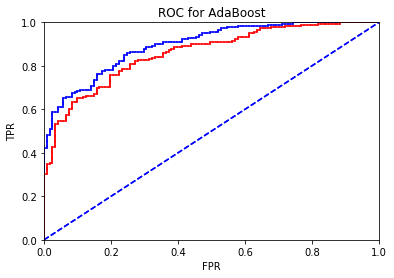

In [274]:
ax2 = plotROC(addClassEst10,labelArr,ax,'red')
plt.show() 
# 这里的绘图存在一定问题
# 注意一旦一张图已经被绘制，重新绘制需要使用别的方法
# 两条曲线嵌套，外层的